In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import re
import numpy as np

In [222]:
MY_PC = '.'
MY_DRIVE = '/content/drive/MyDrive/KFUPM/ICS485 Machine Learning/machine-learning'


working_on = MY_PC

# Reading the data

In [223]:
train_data = pd.read_csv(working_on + "/preprocessed_data/train_data.csv")
val_data = pd.read_csv(working_on + "/preprocessed_data/val_data.csv")
test_data = pd.read_csv(working_on + "/preprocessed_data/test_data.csv")

### Deviding training into labeled and unlabeld

In [224]:
train_labeled = train_data.sample(100)
train_unlabeled = train_data.drop(train_labeled.index)
train_labeled.shape, train_unlabeled.shape

((100, 17), (6614, 17))

### Removing all the labels from train_unlabeled

In [225]:
train_unlabeled["Y"] = np.nan

### Some info of the labeled data

In [226]:
train_labeled.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X13_ FC11,X13_ FC13,X13_ FC14,X14_ CA23,X14_ CA50,X14_ CA59,Y
2839,1.690109,1.775621,2.123813,0.354031,-0.362258,0.653786,-3.612883,-1.243124,1.817201,-0.162165,1.0,0.0,0.0,0.0,0.0,0.0,Toyota
5656,0.946321,0.179554,-0.959454,-0.966625,-0.777088,0.128958,0.330549,0.995112,0.321741,0.410855,1.0,0.0,0.0,0.0,0.0,0.0,GMC
3739,0.330255,0.019739,-1.433803,-0.084214,-0.757334,-0.155674,0.260131,0.757002,0.345107,-0.410659,0.0,1.0,0.0,0.0,0.0,0.0,BMW
1919,0.440446,-0.491300,0.463592,-0.273725,-0.026444,0.125355,1.105152,-0.385927,-1.103619,-0.947826,0.0,1.0,0.0,0.0,0.0,0.0,BMW
2721,-1.512936,1.132600,1.412290,-0.255958,0.645184,-0.559203,-2.415770,1.137979,2.214432,-1.037457,0.0,0.0,1.0,0.0,0.0,0.0,Honda


,Column,Non-Null Count,Dtype,Unique Values
Y,Y,100,object,6
X1,X1,100,float64,98
X2,X2,100,float64,89
X3,X3,100,float64,32
X4,X4,100,float64,66
X5,X5,100,float64,69
X6,X6,100,float64,97
X7,X7,100,float64,61
X8,X8,100,float64,52
X9,X9,100,float64,75


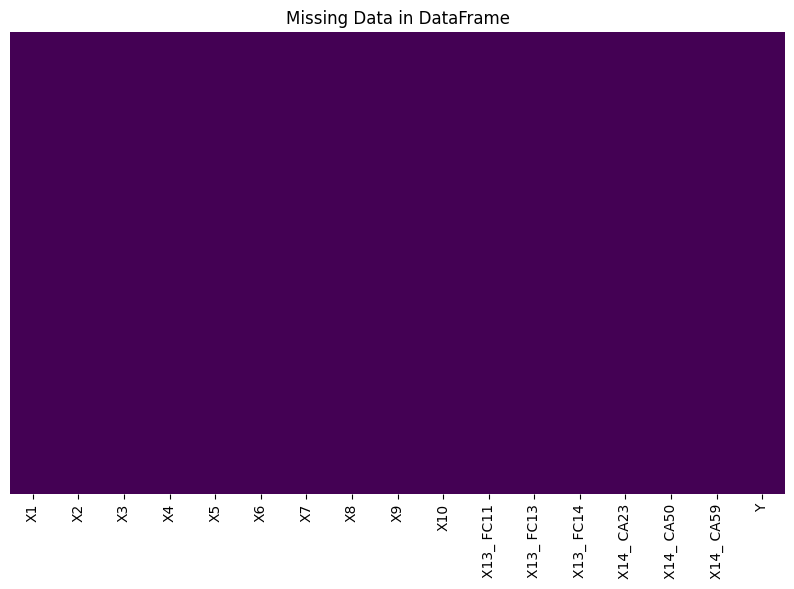

In [227]:
def display_dataframe_summary(dataframe, sort_by='Column'):

    summary = pd.DataFrame({
        'Column': dataframe.columns,
        'Non-Null Count': dataframe.notnull().sum(),
        'Dtype': dataframe.dtypes,
        'Unique Values': dataframe.nunique()
    })

    # Extracting numerical part from column names for sorting
    summary['Sort Key'] = summary['Column'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)

    # Sorting the summary DataFrame
    if sort_by == 'Column':
        summary = summary.sort_values(by='Sort Key', ascending=True)
    else:
        summary = summary.sort_values(by=sort_by, ascending=True)

    summary = summary.drop('Sort Key', axis=1)  # Remove the auxiliary sort key column

    # Display the summary
    display(summary)

    # Plotting missing data
    plt.figure(figsize=(10, 6))
    sns.heatmap(dataframe.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Data in DataFrame')
    plt.show()

# Call the function with your DataFrame
display_dataframe_summary(train_labeled, sort_by='Column')


In [228]:
X_train_labeled = train_labeled.drop('Y', axis=1)
y_train_labeled = pd.get_dummies(train_labeled['Y'])

X_train_unlabeled = train_unlabeled.drop('Y', axis=1)


X_val = val_data.drop('Y', axis=1)
y_val = pd.get_dummies(val_data['Y'])

X_test = test_data.drop('Y', axis=1)
y_test = pd.get_dummies(test_data['Y'])


In [229]:
classes = train_labeled["Y"].unique()
num_classes = y_train_labeled.shape[1]
input_features = X_train_labeled.shape[1]
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

print(f"The classes is: {classes}")
print(f"Number of classes: {num_classes}")
print(f"Number of features: {input_features}")
print(f"X_train shape: {X_train_labeled.shape}, y_train shape: {y_train_labeled.shape}" )

print(categorical_cols)

The classes is: ['Toyota' 'GMC' 'BMW' 'Honda' 'Mercedes' 'Ford']
Number of classes: 6
Number of features: 16
X_train shape: (100, 16), y_train shape: (100, 6)
Index(['Y'], dtype='object')


# Building Model

In [230]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# Initial model parameters
min_samples_split = 2
min_samples_leaf = 1
max_depth = None
criterion = "entropy"
iteration = 1  # Set the number of iterations for active learning
num_samples_to_move = 30  # Number of samples to move in each iteration

while len(X_train_unlabeled) > 0:
    # Train the model
    model = RandomForestClassifier(min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf , max_depth=max_depth, criterion=criterion, random_state=777)
    model.fit(X_train_labeled, y_train_labeled)

    # Evaluate the model
    ta = f1_score(y_train_labeled, model.predict(X_train_labeled), average='weighted')
    va = f1_score(y_val, model.predict(X_val), average='weighted')
    print(f"Iteration {iteration}:")
    print(f"  Train F1 score: {ta:.2f}")
    print(f"  Validation F1 score: {va:.2f}")

    # Predict on the unlabeled data
    unlabeled_probs = model.predict_proba(X_train_unlabeled)
    
    # Compute least confidence scores
    num_labels = unlabeled_probs.shape[1]
    confidence_scores = unlabeled_probs.max(axis=1)
    uncertainty_scores = (1 - confidence_scores) * (num_labels / (num_labels - 1))

    # Select the samples with the highest uncertainty
    # Ensure uncertain_indices is a one-dimensional array
    uncertain_indices = np.argsort(-uncertainty_scores)[:num_samples_to_move].flatten()
    selected_samples = X_train_unlabeled.iloc[uncertain_indices]
    # Use the selected indices to predict
    selected_labels = model.predict(X_train_unlabeled.iloc[uncertain_indices])

    # Ensure that the selected_labels are in the correct format
    # Convert to a numpy array if it's not already
    selected_labels = np.array(selected_labels)
    
    # Update the labeled dataset
    X_train_labeled = pd.concat([X_train_labeled, selected_samples])
    y_train_labeled = np.concatenate([y_train_labeled, selected_labels])

    # Update the unlabeled dataset by dropping the selected indices
    X_train_unlabeled = X_train_unlabeled.drop(selected_samples.index)
    # Make sure to reset index to avoid future index misalignment
    X_train_unlabeled.reset_index(drop=True, inplace=True)

    print(f"  Number of samples in labeled dataset: {len(X_train_labeled)}")
    print(f"  Number of samples in unlabeled dataset: {len(X_train_unlabeled)}")
    print("-" * 100)
    iteration += 1





Iteration 1:
  Train F1 score: 1.00
  Validation F1 score: 0.64


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [ ]:
y_train_labeled

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [ ]:
import xgboost as xgb
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# Initial model parameters
n_estimator = 1000
max_depth = 7
learning_rate = 0.1
num_iterations = 150  # Set the number of iterations for active learning
num_samples_to_move = 50  # Number of samples to move in each iteration

for iteration in range(num_iterations):
    # Train the model
    model = xgb.XGBClassifier(n_estimators=n_estimator, max_depth=max_depth, learning_rate=learning_rate, random_state=777)
    model.fit(X_train_labeled, y_train_labeled)

    # Evaluate the model
    ta = f1_score(y_train_labeled, model.predict(X_train_labeled), average='weighted')
    va = f1_score(y_val, model.predict(X_val), average='weighted')
    print(f"Iteration {iteration}:")
    print(f"  Train F1 score: {ta:.2f}")
    print(f"  Validation F1 score: {va:.2f}")

    # Predict on the unlabeled data
    unlabeled_probs = model.predict_proba(X_train_unlabeled)
    unlabeled_predictions = model.predict(X_train_unlabeled)

    # Select the most confident predictions
    most_confident_indices = np.argsort(-unlabeled_probs.max(axis=1))[:num_samples_to_move]
    selected_samples = X_train_unlabeled.iloc[most_confident_indices]
    selected_labels = unlabeled_predictions[most_confident_indices]

    # Ensure that the selected_labels are in the correct format
    # Convert to a numpy array if it's not already
    selected_labels = np.array(selected_labels)

    # Check for NaN or invalid values in selected_labels and handle them if necessary
    # For example, you can replace NaN with a default class or remove such samples

    # Update the labeled dataset
    X_train_labeled = pd.concat([X_train_labeled, selected_samples])
    y_train_labeled = np.concatenate([y_train_labeled, selected_labels])

    # Update the unlabeled dataset by dropping the selected indices
    X_train_unlabeled.drop(selected_samples.index, inplace=True)

    print(f"  Number of samples in labeled dataset: {len(X_train_labeled)}")
    print(f"  Number of samples in unlabeled dataset: {len(X_train_unlabeled)}")
    print("-" * 100)



